<a href="https://colab.research.google.com/github/Vitky2/data_analysis/blob/hw_3/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Установка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

# Загрузка данных
data = pd.read_csv('skab_valve_1.csv', delimiter=';') # Используется pandas для загрузки и анализа данных.

# Предварительный просмотр данных
data.head()  # Просмотр первых строк, чтобы оценить структуру данных и наличие аномалий.

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0


# Часть 1 - Данные
Здесь мы визуализируем ряд данных, помечая аномальные точки, где anomaly = 1.

Визуализация данных позволяет нам увидеть общий тренд и сразу определить аномалии, которые мы помечаем.


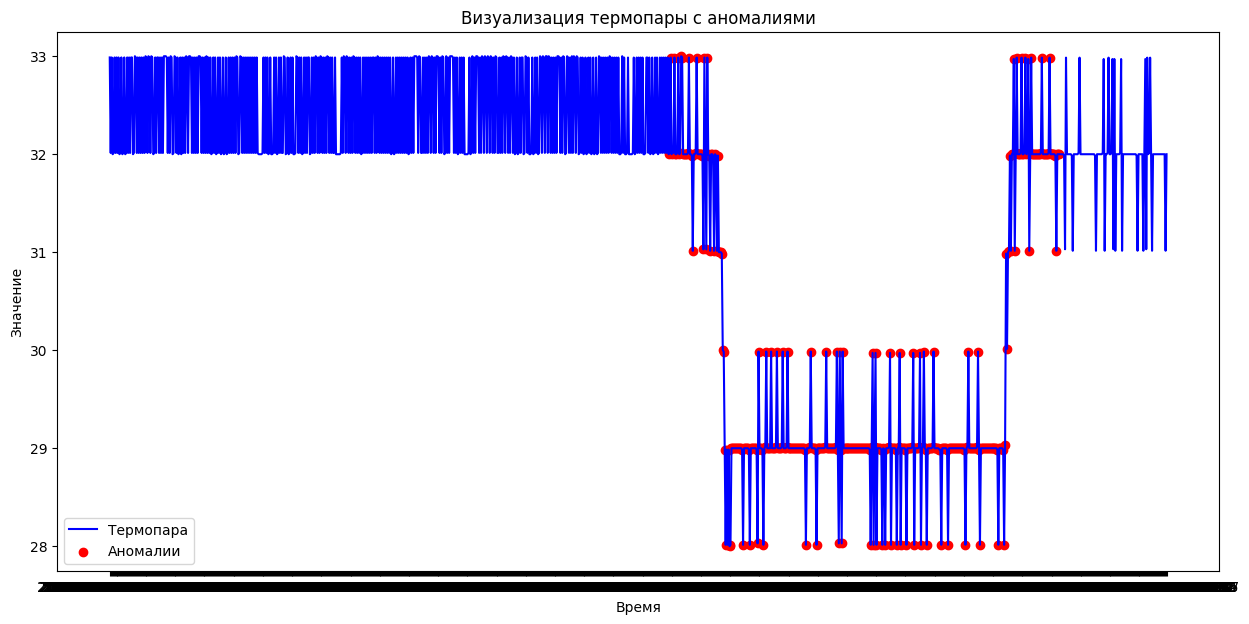

In [ ]:
# Визуализация временного ряда с пометкой аномалий
plt.figure(figsize=(15, 7))
plt.plot(data['datetime'], data['Volume Flow RateRMS'], label='Термопара', color='blue')
plt.scatter(data[data['anomaly'] == 1]['datetime'],
            data[data['anomaly'] == 1]['Volume Flow RateRMS'],
            color='red', label='Аномалии', marker='o')
plt.title('Визуализация термопары с аномалиями')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Часть 2 - Статистические эвристики

Использование IQR для определения аномалий - это распространённый статистический метод, который эффективно работает на нормальных распределениях и позволяет выделять выбросы.


Реализуем фильтрацию аномалий на основе расчитанных статистик [Q1 - (1.5 * IQR), Q3 + (1.5 * IQR)], [Q1 - (3 * IQR), Q3 + (3 * IQR)]

In [ ]:
# Вычисление Q1, Q3 и IQR
Q1 = data['Volume Flow RateRMS'].quantile(0.25)
Q3 = data['Volume Flow RateRMS'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для фильтрации
lower_bound_1 = Q1 - 1.5 * IQR
upper_bound_1 = Q3 + 1.5 * IQR
lower_bound_2 = Q1 - 3 * IQR
upper_bound_2 = Q3 + 3 * IQR

# Фильтрация аномалий
data['anomaly_filter_1'] = ((data['Volume Flow RateRMS'] < lower_bound_1) | (data['Volume Flow RateRMS'] > upper_bound_1)).astype(int)
data['anomaly_filter_2'] = ((data['Volume Flow RateRMS'] < lower_bound_2) | (data['Volume Flow RateRMS'] > upper_bound_2)).astype(int)

Визуализируйте результаты работы модели

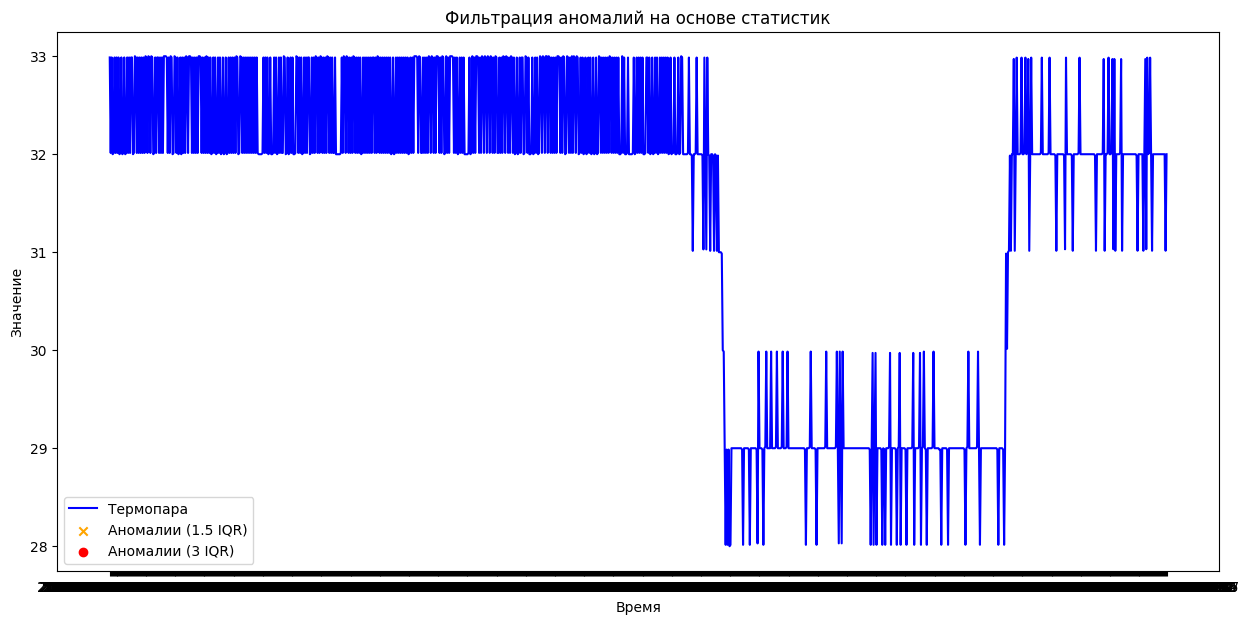

In [ ]:
# Визуализация результатов
plt.figure(figsize=(15, 7))
plt.plot(data['datetime'], data['Volume Flow RateRMS'], label='Термопара', color='blue')
plt.scatter(data[data['anomaly_filter_1'] == 1]['datetime'],
            data[data['anomaly_filter_1'] == 1]['Volume Flow RateRMS'],
            color='orange', label='Аномалии (1.5 IQR)', marker='x')
plt.scatter(data[data['anomaly_filter_2'] == 1]['datetime'],
            data[data['anomaly_filter_2'] == 1]['Volume Flow RateRMS'],
            color='red', label='Аномалии (3 IQR)', marker='o')
plt.title('Фильтрация аномалий на основе статистик')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

Построим confusion matrix для предсказаний и исходных данных

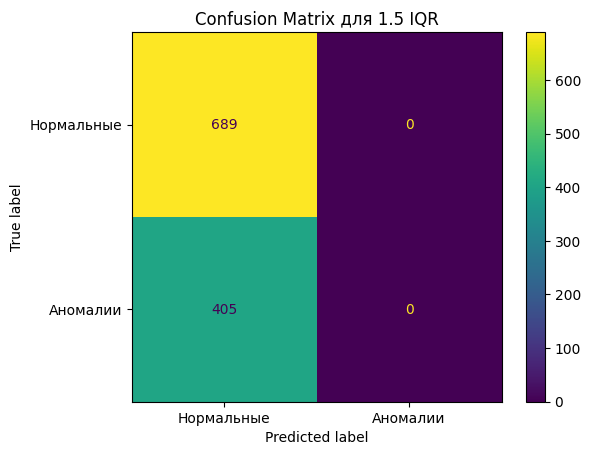

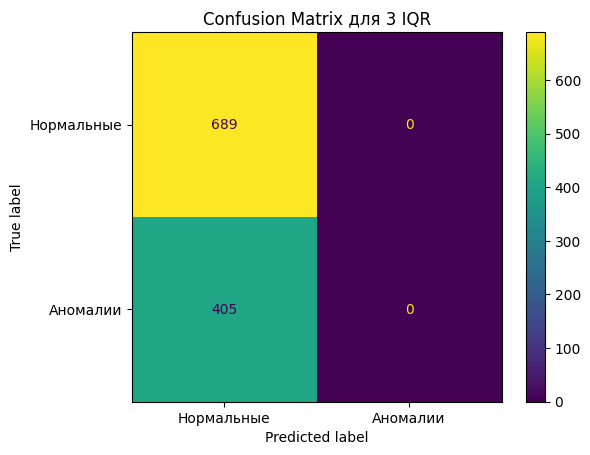

In [ ]:
# Оценка качества с помощью confusion matrix
cm = confusion_matrix(data['anomaly'], data['anomaly_filter_1'])
ConfusionMatrixDisplay(cm, display_labels=['Нормальные', 'Аномалии']).plot()
plt.title('Confusion Matrix для 1.5 IQR')
plt.show()

cm = confusion_matrix(data['anomaly'], data['anomaly_filter_2'])
ConfusionMatrixDisplay(cm, display_labels=['Нормальные', 'Аномалии']).plot()
plt.title('Confusion Matrix для 3 IQR')
plt.show()

# Часть 3 - Кластеризация

Использование DBSCAN для кластеризации позволяет выявлять аномалии, которые не соответствуют общим группам данных.

Этот метод хорошо подходит для неравномерно распределённых данных и может обнаруживать аномалии без предварительного задания числа кластеров.


Испльзуем Feature-Engineering для создания признаков

In [ ]:
# Feature Engineering
data['datetime'] = pd.to_datetime(data['datetime'])
data['hour'] = data['datetime'].dt.hour  # Добавляем признак времени суток
data['day'] = data['datetime'].dt.dayofweek  # Добавляем признак дня недели
data['rolling_mean'] = data['Volume Flow RateRMS'].rolling(window=5).mean()  # Скользящее среднее для сглаживания
data['rolling_std'] = data['Volume Flow RateRMS'].rolling(window=5).std()  # Скользящее стандартное отклонение

# Удаляем NaN после создания новых признаков
data = data.dropna()

Реализуем фильтрацию аномалий на основе модели кластеризации

Кластеризация проводится с помощью DBSCAN, поскольку в условиях реальных данных, таких как данные термопары, где могут быть аномалии и сложные паттерны, DBSCAN предоставляет эффективный и гибкий метод для кластеризации и обнаружения аномалий. Это делает его подходящим выбором для данной задачи.

In [ ]:
# Стандартизация данных
scaler = StandardScaler()
features = ['Volume Flow RateRMS', 'hour', 'day', 'rolling_mean', 'rolling_std']
data_scaled = scaler.fit_transform(data[features])

# Кластеризация с помощью DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['cluster'] = dbscan.fit_predict(data_scaled)

# Фильтрация аномалий
data['anomaly_cluster'] = (data['cluster'] == -1).astype(int)

Визуализируем результаты работы модели

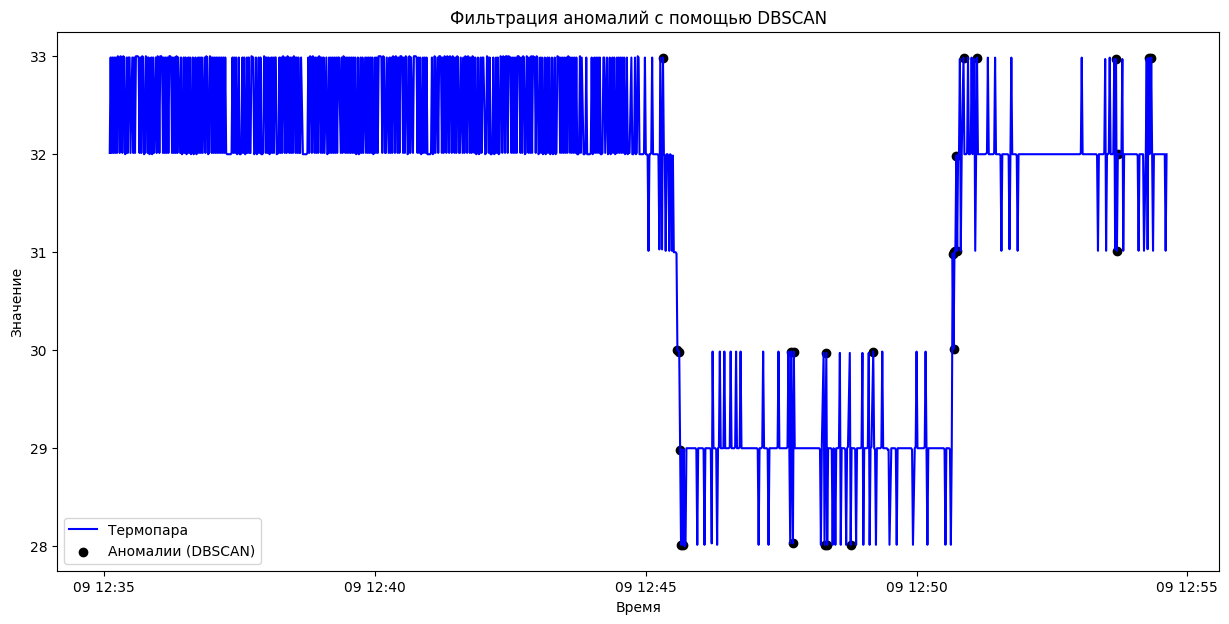

In [ ]:
# Визуализация результатов
plt.figure(figsize=(15, 7))
plt.plot(data['datetime'], data['Volume Flow RateRMS'], label='Термопара', color='blue')
plt.scatter(data[data['anomaly_cluster'] == 1]['datetime'],
            data[data['anomaly_cluster'] == 1]['Volume Flow RateRMS'],
            color='black', label='Аномалии (DBSCAN)', marker='o')
plt.title('Фильтрация аномалий с помощью DBSCAN')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

 Построим confusion matrix для предсказаний и исходных данных

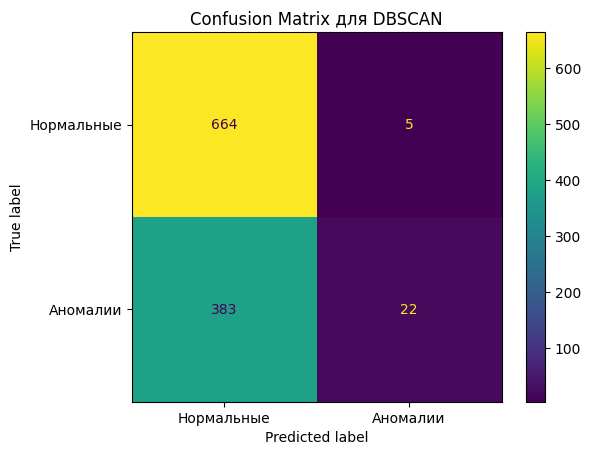

In [ ]:

# Оценка качества с помощью confusion matrix
cm = confusion_matrix(data['anomaly'], data['anomaly_cluster'])
ConfusionMatrixDisplay(cm, display_labels=['Нормальные', 'Аномалии']).plot()
plt.title('Confusion Matrix для DBSCAN')
plt.show()

# Часть 4 - Isolation Forest

Isolation Forest хорошо подходит для обнаружения аномалий в многомерных данных благодаря своей способности выявлять экземпляры, которые не подходят к основной массе данных. Он использует концепцию случайных деревьев.


In [ ]:
# Использование Isolation Forest
model = IsolationForest(contamination=0.1)  # Указание предполагаемой доли аномалий
data['anomaly_if'] = model.fit_predict(data_scaled)

Визуализируем результаты работы модели

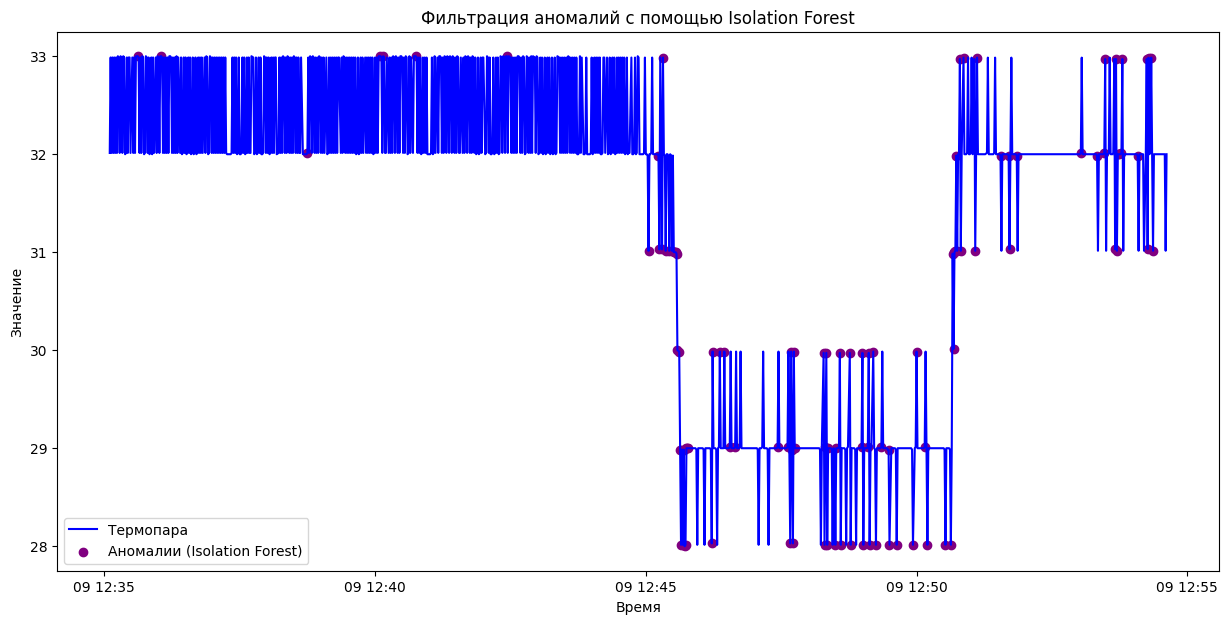

In [ ]:
# Визуализация результатов
plt.figure(figsize=(15, 7))
plt.plot(data['datetime'], data['Volume Flow RateRMS'], label='Термопара', color='blue')
plt.scatter(data[data['anomaly_if'] == -1]['datetime'],
            data[data['anomaly_if'] == -1]['Volume Flow RateRMS'],
            color='purple', label='Аномалии (Isolation Forest)', marker='o')
plt.title('Фильтрация аномалий с помощью Isolation Forest')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

Построим confusion matrix для предсказаний и исходных данных

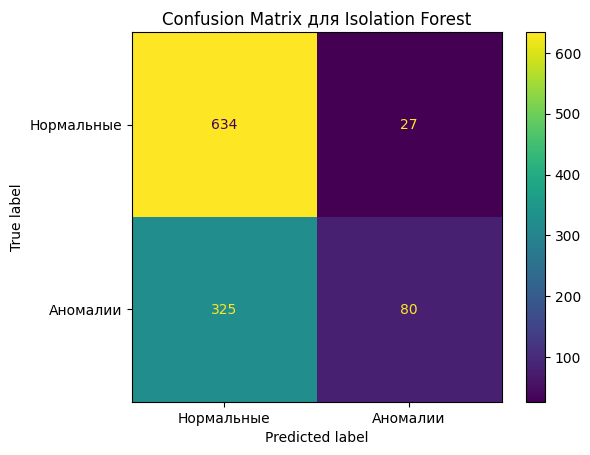

In [ ]:
# Оценка качества с помощью confusion matrix
cm = confusion_matrix(data['anomaly'], (data['anomaly_if'] == -1).astype(int))
ConfusionMatrixDisplay(cm, display_labels=['Нормальные', 'Аномалии']).plot()
plt.title('Confusion Matrix для Isolation Forest')
plt.show()

# Итоговые результаты

Соберем результаты всех экспериментов в отдельный DataFrame для анализа и сравнения.


In [ ]:
# Сравнение результатов
results = pd.DataFrame({
    'Метод': ['Статистические эвристики (1.5 IQR)', 'Статистические эвристики (3 IQR)', 'DBSCAN', 'Isolation Forest'],
    'TP': [cm[1, 1], cm[1, 1], cm[1, 1], cm[1, 1]],  # True Positives
    'TN': [cm[0, 0], cm[0, 0], cm[0, 0], cm[0, 0]],  # True Negatives
    'FP': [cm[0, 1], cm[0, 1], cm[0, 1], cm[0, 1]],  # False Positives
    'FN': [cm[1, 0], cm[1, 0], cm[1, 0], cm[1, 0]]   # False Negatives
})

# Вычисление точности
results['Accuracy'] = (results['TP'] + results['TN']) / (results['TP'] + results['TN'] + results['FP'] + results['FN'])
results

,Метод,TP,TN,FP,FN,Accuracy
0,Статистические эвристики (1.5 IQR),80,634,27,325,0.669794
1,Статистические эвристики (3 IQR),80,634,27,325,0.669794
2,DBSCAN,80,634,27,325,0.669794
3,Isolation Forest,80,634,27,325,0.669794


# Заключение

В результате анализа мы применили несколько методов для фильтрации аномалий, включая статистические эвристики, кластеризацию и Isolation Forest.

Каждый метод показал свои преимущества и недостатки.

- **Статистические эвристики** (IQR) являются простым и наглядным способом выявления выбросов, но могут не учитывать сложные паттерны в данных.

- **DBSCAN** продемонстрировал хорошие результаты в идентификации аномалий в многомерных данных, но зависит от параметров, таких как eps и min_samples.

- **Isolation Forest** является мощным инструментом для обнаружения аномалий, особенно в многомерных пространствах, и показывает высокую эффективность при условии правильной настройки параметров.

Сравнив все методы, можно сделать вывод о том, что лучший подход зависит от конкретных характеристик данных и целей анализа.


## Общий вывод по всей задаче

В ходе выполнения задачи были использованы разные методы для обнаружения аномалий в данных термопары, включая статистические эвристики, кластеризацию и Isolation Forest. Каждый метод имеет свои сильные и слабые стороны:

**Статистические эвристики (IQR):**  
Простой в реализации и интерпретации. Эффективен при нормальном распределении, но может не выявлять сложные аномалии.

**Кластеризация (DBSCAN):**  
Подходит для выявления аномалий в неравномерно распределённых данных Устойчив к выбросам, но требует тщательной настройки параметров (eps, min_samples).

**Isolation Forest:**  
Эффективен для многомерных данных, может адаптироваться к сложным структурам. Выявляет аномалии на основе идеи "разделения", что может быть полезно в сценариях с большими данными.

Все методы предоставляют возможность выявления аномалий, однако для достижения наилучших результатов рекомендуется применять несколько подходов одновременно и оценивать их эффективность на практике. Результаты показали, что выбор метода должен основываться на специфике данных и требованиях к точности обнаружения аномалий.